# Install packages

In [180]:
!pip install transformers

# Imports

In [181]:
import transformers
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from torch import nn, optim
from torch.utils import data

from collections import defaultdict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.2)

HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 31415
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Prepare Data

In [182]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 38.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 113MB/s]


In [183]:
# Read the csv data file
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [184]:
# Checking data specs
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


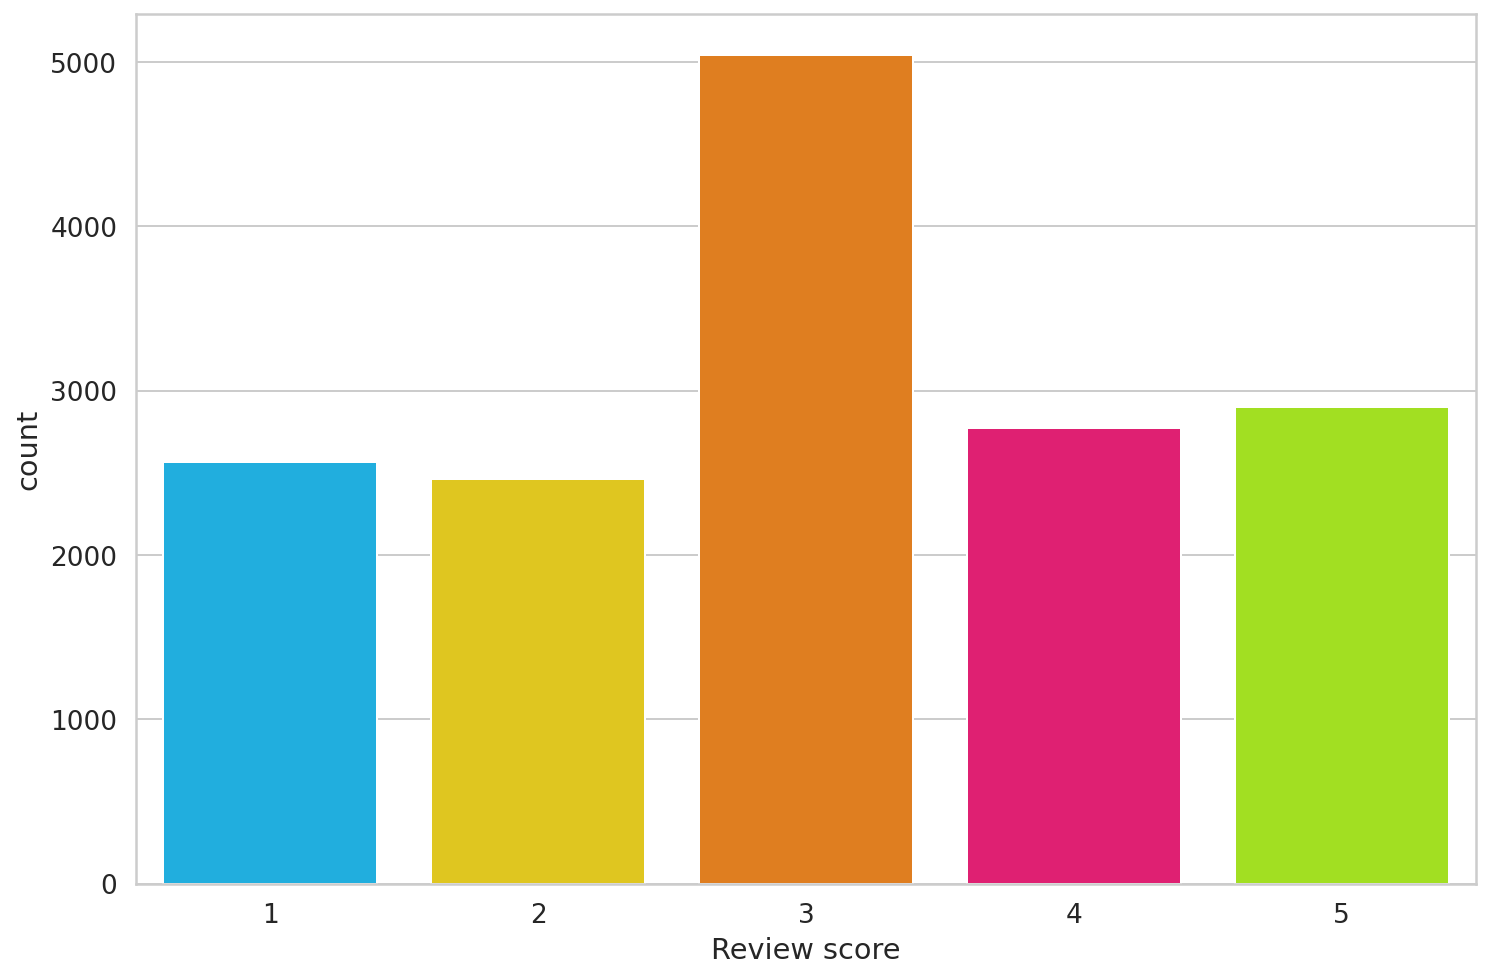

In [185]:
# Plotting review score
sns.countplot(df.score)
plt.xlabel('Review score');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Review sentiment')

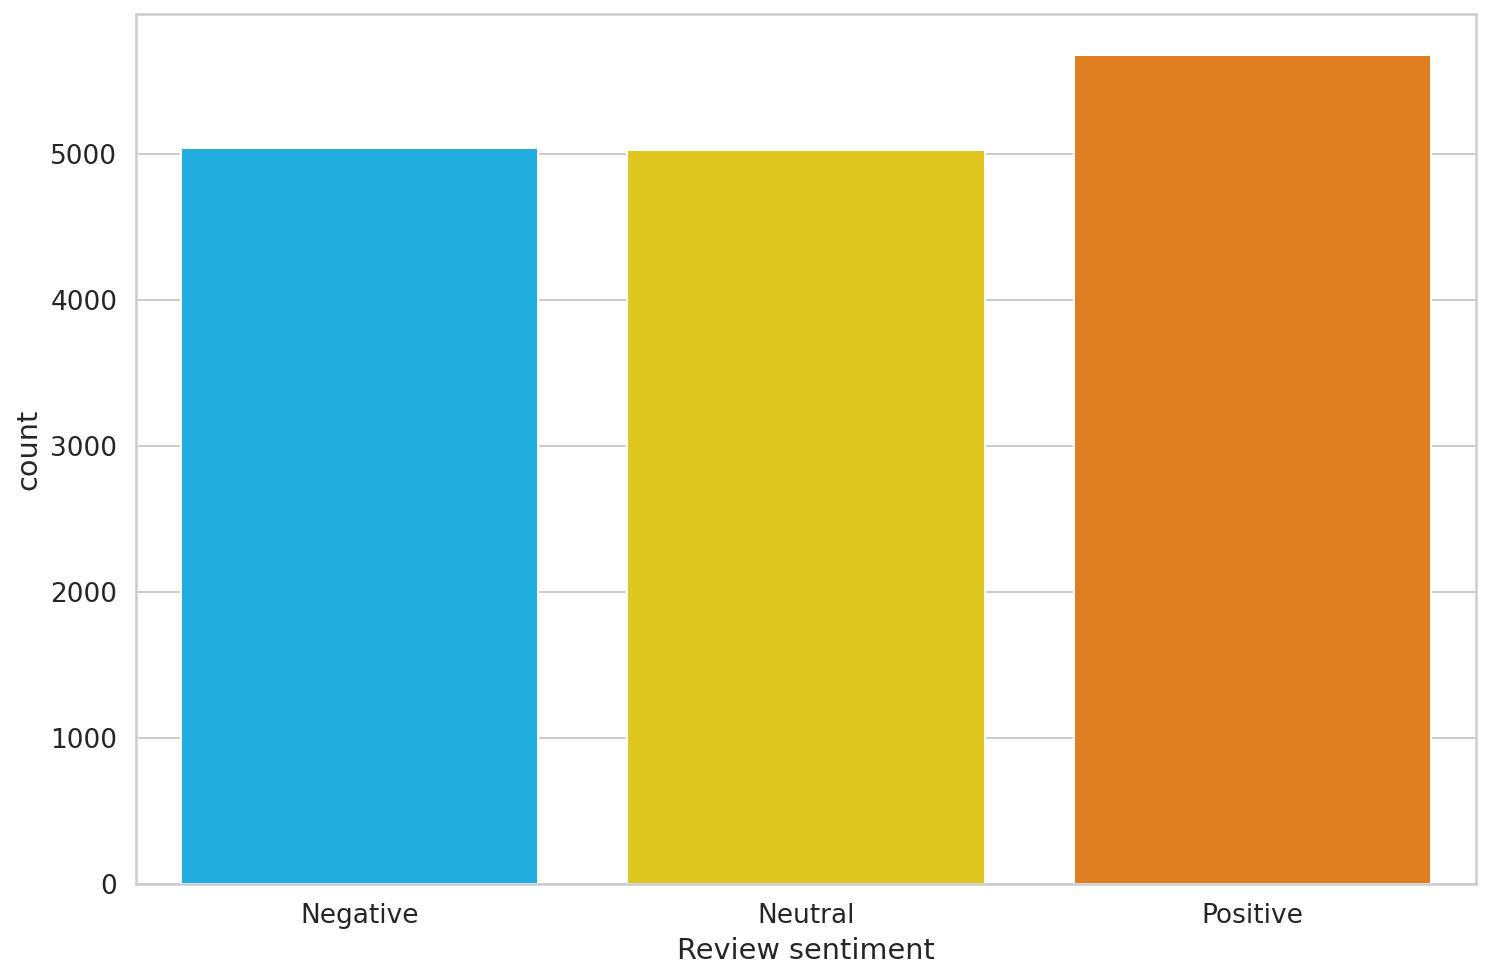

In [186]:
# Convert review score into sentiment value
def to_sentiment(rating):
    rating = int(rating)
    if rating == 3:
        # neutral sentiment
        return 0
    elif rating < 3:
        # negative sentiment
        return 1
    else:
        # positive sentiment
        return 2

# Plotting review sentiment
CLASSES = ['Negative', 'Neutral', 'Positive']
df['sentiment'] = df.score.apply(to_sentiment)
ax = sns.countplot(df.sentiment)
ax.set_xticklabels(CLASSES)
plt.xlabel('Review sentiment')

# Preprocess data

In [187]:
# Getting the tokenizer
MODEL_NAME = 'roberta-base'
tokenizer = transformers.RobertaTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

In [188]:
# Testing the tokenizer
sample_text = 'The quick brown fox jumps over the lazy dog 3 times. And it run away!'
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(tokens)
print(token_ids)

['The', 'Ġquick', 'Ġbrown', 'Ġfox', 'Ġjumps', 'Ġover', 'Ġthe', 'Ġlazy', 'Ġdog', 'Ġ3', 'Ġtimes', '.', 'ĠAnd', 'Ġit', 'Ġrun', 'Ġaway', '!']
[133, 2119, 6219, 23602, 13855, 81, 5, 22414, 2335, 155, 498, 4, 178, 24, 422, 409, 328]


In [189]:
# Still testing the tokenizer
encoding = tokenizer.encode_plus(
    sample_text,
    max_length = 32,
    add_special_tokens = True,
    padding = 'max_length',
    return_attention_mask = True,
    return_token_type_ids = False,
    return_tensors = 'pt'
)

encoding.keys()
print(encoding['input_ids'])
print(encoding['attention_mask'])

tensor([[    0,   133,  2119,  6219, 23602, 13855,    81,     5, 22414,  2335,
           155,   498,     4,   178,    24,   422,   409,   328,     2,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


# Choose maximum sequence length

In [190]:
# Creating tokens length array to plot
token_lens = []

for x in df.content:
    tokens = tokenizer.encode(x, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


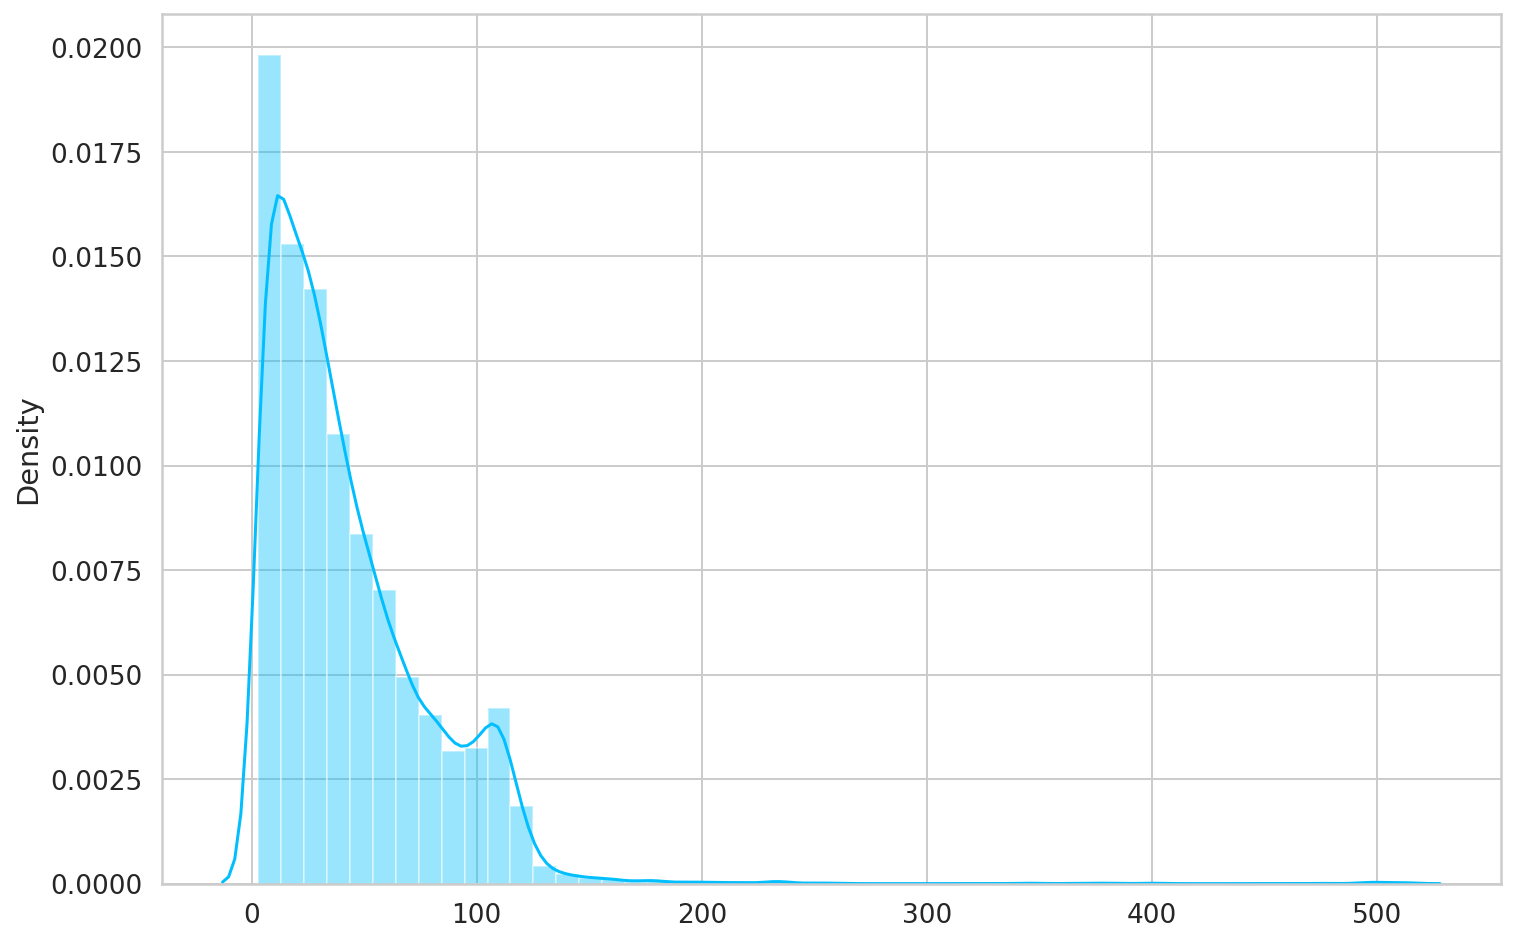

In [191]:
# Plotting tokens length
sns.distplot(token_lens)

# We can see that the maximum length is approximately 128

# Create Dataset


In [192]:
class ReviewDataset(data.Dataset):
    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.review)

    def __getitem__(self, item):
        review = str(self.review[item])

        encoding = tokenizer.encode_plus(
            review,
            max_length = self.max_len,
            add_special_tokens = True,
            padding = 'max_length',
            return_attention_mask = True,
            return_token_type_ids = False,
            return_tensors = 'pt'
        )

        rt = {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(self.target[item], dtype=torch.long)
        }

        return rt

In [193]:
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS = 50

In [194]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)
print(f'Train set: {df_train.shape}')
print(f'Validate set: {df_val.shape}')
print(f'Test set: {df_test.shape}')

Train set: (12596, 12)
Validate set: (1575, 12)
Test set: (1575, 12)


In [195]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = ReviewDataset(
        review = df.content.to_numpy(),
        target = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
    )

    dl = data.DataLoader(
        ds,
        batch_size = batch_size,
        num_workers = 4,
    )
    
    return dl

In [196]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

sample_data = next(iter(train_data_loader))
print(sample_data.keys())
print(sample_data['input_ids'].shape)
print(sample_data['attention_mask'].shape)
print(sample_data['targets'].shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Model

In [197]:
model = transformers.RobertaModel.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [198]:
# Testing out the model
sample_output = model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask']
)

print(sample_output.last_hidden_state.shape)
print(sample_output.pooler_output.shape)

torch.Size([1, 32, 768])
torch.Size([1, 768])


# Classifier

In [199]:
# Creating a classifier
class ReviewSentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(ReviewSentimentClassifier, self).__init__()
        self.roberta = transformers.RobertaModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p = 0.3)
        self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.roberta(
            input_ids = input_ids,
            attention_mask = attention_mask,
            return_dict=False
        )
        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)

In [200]:
model = ReviewSentimentClassifier(len(CLASSES))
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [201]:
input_ids = sample_data['input_ids'].to(device)
attention_mask = sample_data['attention_mask'].to(device)
print(input_ids.shape)
print(attention_mask.shape)
print(model(input_ids, attention_mask))

torch.Size([16, 160])
torch.Size([16, 160])
tensor([[0.3518, 0.3051, 0.3431],
        [0.3460, 0.3096, 0.3445],
        [0.3719, 0.3405, 0.2876],
        [0.3988, 0.3027, 0.2985],
        [0.3628, 0.3250, 0.3122],
        [0.3354, 0.3455, 0.3191],
        [0.3083, 0.3513, 0.3404],
        [0.3359, 0.3469, 0.3172],
        [0.3156, 0.3084, 0.3760],
        [0.3390, 0.3061, 0.3548],
        [0.3489, 0.3250, 0.3261],
        [0.3245, 0.3577, 0.3178],
        [0.3394, 0.3381, 0.3225],
        [0.3532, 0.3099, 0.3369],
        [0.3671, 0.3089, 0.3240],
        [0.3325, 0.3343, 0.3332]], grad_fn=<SoftmaxBackward0>)


# Train

In [202]:
# Defining optimzer and scheduler
optimizer = transformers.AdamW(model.parameters(), lr = 2e-5, correct_bias = False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_func = nn.CrossEntropyLoss().to(device)

In [203]:
def train_epoch(
    model,
    data_loader,
    loss_func,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for x in data_loader:
        input_ids = x['input_ids'].to(device)
        attention_mask = x['attention_mask'].to(device)
        targets = x['targets'].to(device)

        output = model(
            input_ids = input_ids,
            attention_mask = attention_mask
        )

        _, preds = torch.max(output, dim = 1)
        loss = loss_func(output, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.doubles() / n_examples, np.means(losses)

In [204]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    # disable torch gradient function so torch is faster
    with torch.no_grad():
        for x in data_loader:
            input_ids = x['input_ids'].to(device)
            attention_mask = x['attention_mask'].to(device)
            targets = x['targets'].to(device)

            output = model(
                input_ids = input_ids,
                attention_mask = attention_mask
            )

            _, preds = torch.max(output, dim = 1)
            loss = loss_func(output, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

    return correct_predictions.doubles() / n_examples, np.means(losses)

In [ ]:
history = defaultdict(list)
bess_acc = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_func,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'train loss {train_loss}, accuracy {train_acc}')

    val_acc, val_loss = val_model(
        model,
        val_data_loader,
        loss_func,
        device,
        len(df_train)
    )

    print(f'val loss {train_loss}, accuracy {train_acc}')

    print('-' * 10)

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state.dict(), 'model.bin')
        best_acc = val_acc

Epoch 0/50
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
